In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 8]

In [151]:
# constants 
TIME_RANGE_LEFT = 10
TIME_RANGE_RIGHT = 5
PREDICTED_RANGE  = 1

In [40]:
# read data
imu = pd.read_csv(
    'data/indoor_forward_9_snapdragon_with_gt/imu.txt',
    delimiter=' ', index_col='#').set_index('timestamp').rename(
    dict(zip(
        ['ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z'],
        ['avdx', 'avdy', 'avdz', 'accdx', 'accdy', 'accdz']
    )), axis=1
)
groundtruth = pd.read_csv(
    'data/indoor_forward_9_snapdragon_with_gt/groundtruth.txt',
    delimiter=' ')\
    .rename(dict(zip(
        ['#', 'timestamp', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'],
        ['timestamp', 'X', 'Y', 'Z', 'qx', 'qy', 'qz', 'qw', 'tmp'],
    )), axis=1)\
    .drop(['tmp'], axis=1).set_index('timestamp')


imu_test = pd.read_csv(
    'data/indoor_forward_6_snapdragon_with_gt/indoor_forward_6_snapdragon_with_gt/imu.txt',
    delimiter=' ', index_col='#').set_index('timestamp').rename(
    dict(zip(
        ['ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z'],
        ['avdx', 'avdy', 'avdz', 'accdx', 'accdy', 'accdz']
    )), axis=1
)
groundtruth_test = pd.read_csv(
    'data/indoor_forward_6_snapdragon_with_gt/indoor_forward_6_snapdragon_with_gt/groundtruth.txt',
    delimiter=' ')\
    .rename(dict(zip(
        ['#', 'timestamp', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'],
        ['timestamp', 'X', 'Y', 'Z', 'qx', 'qy', 'qz', 'qw', 'tmp'],
    )), axis=1)\
    .drop(['tmp'], axis=1).set_index('timestamp')

In [41]:
def derivative_data_by_time(df: pd.DataFrame, column):
    res = []
    for i in range(df.shape[0] - 1):
        t0, t1 = df.index.values[i:i+2]
        d0, d1 = df[column].values[i:i+2]
        res.append((d1 - d0)/(t1 - t0))
    res.append(None)
    return res

def conv_quaternion_to_rotation_matrix(x, y, z, w):
    return np.array([
        [1 - 2 * (y**2 + z**2), 2 * (x * y - w * z),   2 * (x * z + w * y)  ],
        [2 * (x * y + w * z),   1 - 2 * (x**2 + z**2), 2 * (y * z - w * x)  ],
        [2 * (x * z - w * y),   2 * (z * y + w * x),   1 - 2 * (y**2 + x**2)]
    ])

def add_rotation_params(df):
    keys = ['xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz']
    lists = dict(zip(
        keys,
        list(map(lambda x: list(), range(9)))
    ))
    for i in range(df.shape[0]):
        x, y, z, w = df.iloc[[i]][['qx', 'qy', 'qz', 'qw']].values[0]
        matrix = conv_quaternion_to_rotation_matrix(x, y, z, w)
        params = matrix.reshape(9)
        list(map(lambda i: lists[keys[i]].append(params[i]),range(9)))
    list(map(lambda key: df.insert(0, key, lists[key]), keys))
    
def get_drone_acc(x1, x2, x3, x4, x5, x6, x7, x8, x9, y1, y2, y3):
    r1 = np.array([x1, x2, x3, y1], dtype=np.float128)
    r2 = np.array([x4, x5, x6, y2], dtype=np.float128)
    r3 = np.array([x7, x8, x9, y3], dtype=np.float128)
    r1 = r1 / x1
    r2 = r2 / x4
    r3 = r3 / x7
    r2 = r2 - r1
    r3 = r3 - r1
    c3 = r2[1]
    c2 = r3[1]
    r2 = r2 * c2
    r3 = r3 * c3
    r3 = r3 - r2
    a3 = r3[3] / r3[2]
    a2  = (r2[3] - r2[2] * a3) / r2[1] 
    a1  = (r1[3] - r1[1] * a2 - r1[2] * a3) / r1[0]
    return a1, a2, a3

In [42]:

groundtruth['pVx'] = derivative_data_by_time(groundtruth, 'X')
groundtruth['pax'] = derivative_data_by_time(groundtruth, 'pVx')

groundtruth['pVy'] = derivative_data_by_time(groundtruth, 'Y')
groundtruth['pay'] = derivative_data_by_time(groundtruth, 'pVy')

groundtruth['pVz'] = derivative_data_by_time(groundtruth, 'Z')
groundtruth['paz'] = derivative_data_by_time(groundtruth, 'pVz')

add_rotation_params(groundtruth)

acc = {'ax':[], 'ay':[], 'az':[]}
for i in range(groundtruth.shape[0]):
    x1, x2, x3, x4, x5, x6, x7, x8, x9, y1, y2, y3 = groundtruth.iloc[[i]][['xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz', 'pax', 'pay', 'paz']].values[0]
    ax, ay, az = get_drone_acc(x1, x2, x3, x4, x5, x6, x7, x8, x9, y1, y2, y3)
    acc['ax'].append(ax)
    acc['ay'].append(ay)
    acc['az'].append(az)
    
groundtruth['ax'] = acc['ax']
groundtruth['ay'] = acc['ay']
groundtruth['az'] = acc['az']

groundtruth_test['pVx'] = derivative_data_by_time(groundtruth_test, 'X')
groundtruth_test['pax'] = derivative_data_by_time(groundtruth_test, 'pVx')

groundtruth_test['pVy'] = derivative_data_by_time(groundtruth_test, 'Y')
groundtruth_test['pay'] = derivative_data_by_time(groundtruth_test, 'pVy')

groundtruth_test['pVz'] = derivative_data_by_time(groundtruth_test, 'Z')
groundtruth_test['paz'] = derivative_data_by_time(groundtruth_test, 'pVz')

add_rotation_params(groundtruth_test)

acc = {'ax':[], 'ay':[], 'az':[]}
for i in range(groundtruth_test.shape[0]):
    x1, x2, x3, x4, x5, x6, x7, x8, x9, y1, y2, y3 = groundtruth_test.iloc[[i]][['xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz', 'pax', 'pay', 'paz']].values[0]
    ax, ay, az = get_drone_acc(x1, x2, x3, x4, x5, x6, x7, x8, x9, y1, y2, y3)
    acc['ax'].append(ax)
    acc['ay'].append(ay)
    acc['az'].append(az)
    
groundtruth_test['ax'] = acc['ax']
groundtruth_test['ay'] = acc['ay']
groundtruth_test['az'] = acc['az']

In [152]:
groundtruth.head(3)

,zz,zy,zx,yz,yy,yx,xz,xy,xx,X,...,qw,pVx,pax,pVy,pay,pVz,paz,ax,ay,az
timestamp,,,,,,,,,,,,,,,,,,,,,
1.540823e+09,0.999827,-0.017165,0.007233,-0.004200,-0.586067,-0.810252,0.018147,0.810081,-0.586037,6.952171,...,-0.454896,-0.005687,-0.488017,-0.026489,0.426816,-0.006958,-0.040808,-0.060127,-0.644775,-0.051449
1.540823e+09,0.999827,-0.017114,0.007306,-0.004113,-0.586143,-0.810197,0.018148,0.810026,-0.586112,6.952160,...,-0.454855,-0.006663,-0.445158,-0.025635,0.393744,-0.007040,-0.033311,-0.058341,-0.590810,-0.043003
1.540823e+09,0.999827,-0.017075,0.007370,-0.004039,-0.586209,-0.810150,0.018154,0.809980,-0.586176,6.952146,...,-0.454819,-0.007553,-0.405854,-0.024848,0.356421,-0.007107,-0.028040,-0.051060,-0.537192,-0.036843


In [153]:
groundtruth.columns

Index(['zz', 'zy', 'zx', 'yz', 'yy', 'yx', 'xz', 'xy', 'xx', 'X', 'Y', 'Z',
       'qx', 'qy', 'qz', 'qw', 'pVx', 'pax', 'pVy', 'pay', 'pVz', 'paz', 'ax',
       'ay', 'az'],
      dtype='object')

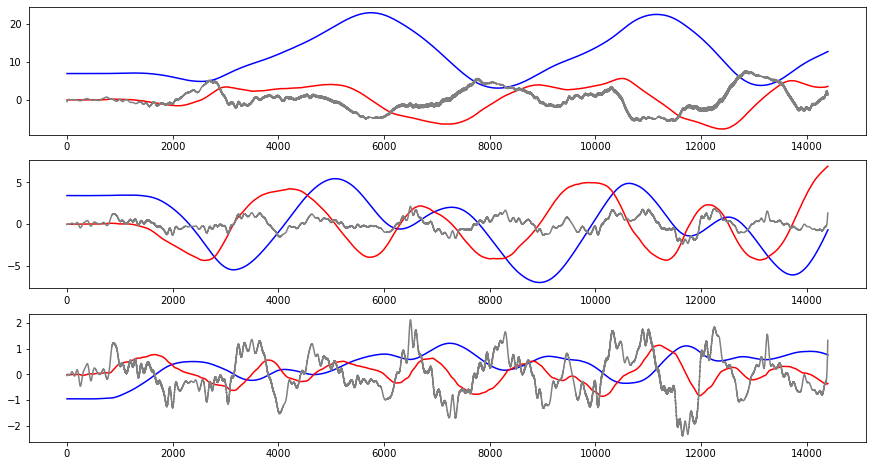

In [154]:
fig = plt.figure(figsize=(15, 8))
px = fig.add_subplot(3, 1, 1)
py = fig.add_subplot(3, 1, 2)
pz = fig.add_subplot(3, 1, 3)

px.plot(groundtruth['X'].values, color='blue')
px.plot(groundtruth['pVx'].values, color='red')
px.plot(groundtruth['pax'].values, color='grey')

py.plot(groundtruth['Y'].values, color='blue')
py.plot(groundtruth['pVy'].values, color='red')
py.plot(groundtruth['paz'].values, color='grey')

pz.plot(groundtruth['Z'].values, color='blue')
pz.plot(groundtruth['pVz'].values, color='red')
pz.plot(groundtruth['paz'].values, color='grey')

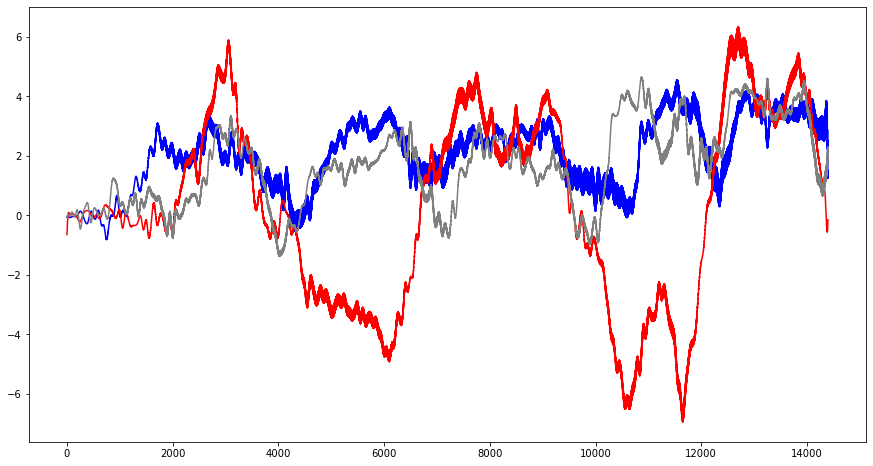

In [155]:
plt.plot(groundtruth['ax'].values, color='blue')
plt.plot(groundtruth['ay'].values, color='red')
plt.plot(groundtruth['az'].values, color='grey')

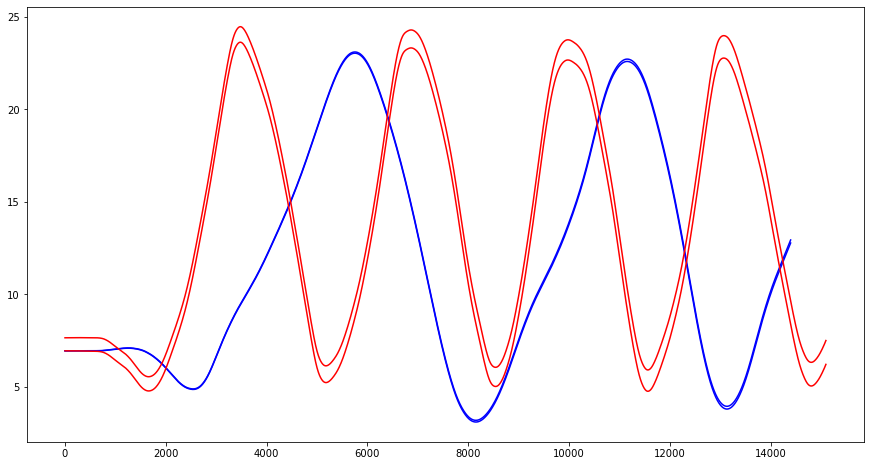

In [193]:
# try to reprodure X by rotarion and acc

pax = groundtruth.ax * groundtruth.xx +  groundtruth.ay * groundtruth.xy +  groundtruth.az * groundtruth.xz  
pVx = [0]
for a, t0, t1 in zip(pax, groundtruth.index.values[:-1], groundtruth.index.values[1:]):
    pVx.append(pVx[-1] + a * (t1 - t0))
X = [groundtruth.X.values[0]]
for v, t0, t1 in zip(pVx, groundtruth.index.values[:-1], groundtruth.index.values[1:]):
    X.append(X[-1] + v * (t1 - t0))
plt.plot(X, color='blue')
plt.plot(groundtruth.X.values, color='blue')


pax = groundtruth_test.ax * groundtruth_test.xx +  groundtruth_test.ay * groundtruth_test.xy +  groundtruth_test.az * groundtruth_test.xz  
pVx = [0]
for a, t0, t1 in zip(pax, groundtruth_test.index.values[:-1], groundtruth_test.index.values[1:]):
    pVx.append(pVx[-1] + a * (t1 - t0))
X = [groundtruth.X.values[0]]
for v, t0, t1 in zip(pVx, groundtruth_test.index.values[:-1], groundtruth_test.index.values[1:]):
    X.append(X[-1] + v * (t1 - t0))
plt.plot(X, color='red')
plt.plot(groundtruth_test.X.values, color='red')


In [219]:
expected_acc = groundtruth[['pax', 'pay', 'paz']].values[:-2] # cat last pair because thay are nulls
expected_rotation = groundtruth[[
    'xx', 'xy', 'xz',
    'yx', 'yy', 'yz',
    'zx', 'zy', 'zz'
]].values[:-2] # cat last pair because size expected_rotation must require expected_acc
expected_data_time_min = groundtruth.index.values.min()
expected_data_time_max = groundtruth.index.values.max()

In [220]:
expected_acc_test = groundtruth_test[['pax', 'pay', 'paz']].values[:-2] # cat last pair because thay are nulls
expected_rotation_test = groundtruth_test[[
    'xx', 'xy', 'xz',
    'yx', 'yy', 'yz',
    'zx', 'zy', 'zz'
]].values[:-2] # cat last pair because size expected_rotation must require expected_acc
expected_data_time_min_test = groundtruth_test.index.values.min()
expected_data_time_max_test = groundtruth_test.index.values.max()

In [221]:
time_first_requried_imu = imu.loc[expected_data_time_min:].index[0]
index_first_requried_imu = imu.index.get_loc(time_first_requried_imu)
time_last_requried_imu = imu.loc[:expected_data_time_max].index[-1]
index_last_requried_imu = imu.index.get_loc(time_last_requried_imu)
firts_index_of_imu_for_input_data = index_first_requried_imu - TIME_RANGE_LEFT
last_index_of_imu_for_input_data = index_last_requried_imu + TIME_RANGE_RIGHT - 1
input_data = imu.iloc[firts_index_of_imu_for_input_data: last_index_of_imu_for_input_data].values

In [222]:
time_first_requried_imu_test = imu_test.loc[expected_data_time_min_test:].index[0]
index_first_requried_imu_test = imu_test.index.get_loc(time_first_requried_imu_test)
time_last_requried_imu_test = imu_test.loc[:expected_data_time_max_test].index[-1]
index_last_requried_imu_test = imu_test.index.get_loc(time_last_requried_imu_test)
firts_index_of_imu_for_input_data_test = index_first_requried_imu_test - TIME_RANGE_LEFT
last_index_of_imu_for_input_data_test = index_last_requried_imu_test + TIME_RANGE_RIGHT - 1
input_data_test = imu_test.iloc[firts_index_of_imu_for_input_data_test: last_index_of_imu_for_input_data_test].values

In [223]:
input_data.shape[0] - expected_acc.shape[0] == TIME_RANGE_LEFT + TIME_RANGE_RIGHT - 1

True

In [224]:
input_data.shape

(14412, 6)

In [225]:
import keras
import tensorflow as tf
from keras import backend as K

In [242]:
class Model6:
    def __init__(self):
        self.model = keras.Sequential([
            keras.layers.LSTM(45, return_sequences=True, input_shape=(TIME_RANGE_LEFT + TIME_RANGE_RIGHT - 1, 6)),
            keras.layers.LSTM(45, return_sequences=True),
            keras.layers.LSTM(45, return_sequences=False),
            keras.layers.Dense(128, activation='tanh'),
            keras.layers.Dense(128, activation='tanh'),
            keras.layers.Dense(128, activation='tanh'),
            keras.layers.Dense(12, activation=None),
            
           
        ])
        self.optim = keras.optimizers.Adam(lr=0.0001)
        
        
    def loss_func(self, expect_acc, expect_rot, predict):
        predict_acc = K.reshape(predict[:, :3], (3000))
        expect_acc = K.reshape(expect_acc, (3000))
        expect_rot = K.reshape(expect_rot, (9000))
        predict_rot = K.reshape(predict[:, 3:], (9000))
        loss_acc = keras.losses.mean_absolute_error(expect_acc, predict_acc)
        loss_rot = keras.losses.mean_absolute_error(expect_rot, predict_rot) * 10
        return loss_rot, loss_acc
        
   
    def train_step(self, input_batch, expected_acc_batch, expected_rot_batch):
        with tf.GradientTape() as tape:
            
            predicet_data = self.model(input_batch, training=True)
            loss_rot, loss_acc = self.loss_func(expected_acc_batch, expected_rot_batch, predicet_data)
            
            loss = loss_rot + loss_acc
            
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optim.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss_rot, loss_acc
        
    def train(self, input_data_list, expected_acc_list, expected_rotation_list,epoches, batch_size): 
        self.loss_acc = []
        self.loss_rot = []
        for epoch in range(1, epoches+1):
            

            for input_data, expected_acc, expected_rot in zip(input_data_list, expected_acc_list, expected_rotation_list):
                for batch_start_index in range(0, expected_acc.shape[0] - batch_size + 1, batch_size):
                    input_batch = []
                    expected_acc_batch = []
                    expected_rot_batch = []
                    for index_in_batch in range(batch_size):
                        input_batch.append(input_data[
                            batch_start_index + index_in_batch: 
                            batch_start_index + index_in_batch + TIME_RANGE_LEFT + TIME_RANGE_RIGHT - 1])
                        expected_acc_batch.append(expected_acc[batch_start_index + index_in_batch])
                        expected_rot_batch.append(expected_rot[batch_start_index + index_in_batch])
                    input_batch = np.array(input_batch)
                    expected_acc_batch = np.array(expected_acc_batch)
                    expected_rot_batch = np.array(expected_rot_batch)
                    loss_rot, loss_acc = self.train_step(input_batch, expected_acc_batch, expected_rot_batch)
                    self.loss_acc.append(loss_acc)
                    self.loss_rot.append(loss_rot)
                    print(f'Ep: {epoch}\tstep {batch_start_index+batch_size}\tacc loss {loss_acc}')

model = Model6()
model.train(
    [input_data, input_data_test], 
    [expected_acc/20, expected_acc_test/20], 
    [expected_rotation/20, expected_rotation_test/20], 
    120, 
    1000)

Ep: 1	step 1000	acc loss 0.05025460943579674
Ep: 1	step 2000	acc loss 0.046658847481012344
Ep: 1	step 3000	acc loss 0.103597491979599
Ep: 1	step 4000	acc loss 0.06609027087688446
Ep: 1	step 5000	acc loss 0.06462199240922928
Ep: 1	step 6000	acc loss 0.10311591625213623
Ep: 1	step 7000	acc loss 0.08122720569372177
Ep: 1	step 8000	acc loss 0.12778280675411224
Ep: 1	step 9000	acc loss 0.10316955298185349
Ep: 1	step 10000	acc loss 0.06595126539468765
Ep: 1	step 11000	acc loss 0.13170042634010315
Ep: 1	step 12000	acc loss 0.15463171899318695
Ep: 1	step 13000	acc loss 0.14702516794204712
Ep: 1	step 14000	acc loss 0.15096651017665863
Ep: 1	step 1000	acc loss 0.04314235597848892
Ep: 1	step 2000	acc loss 0.14969323575496674
Ep: 1	step 3000	acc loss 0.1423104703426361
Ep: 1	step 4000	acc loss 0.24776971340179443
Ep: 1	step 5000	acc loss 0.18144230544567108
Ep: 1	step 6000	acc loss 0.22744958102703094
Ep: 1	step 7000	acc loss 0.2257123589515686
Ep: 1	step 8000	acc loss 0.23905755579471588
Ep: 1	st

Ep: 7	step 10000	acc loss 0.06391144543886185
Ep: 7	step 11000	acc loss 0.12737983465194702
Ep: 7	step 12000	acc loss 0.14724886417388916
Ep: 7	step 13000	acc loss 0.1358359307050705
Ep: 7	step 14000	acc loss 0.1397673487663269
Ep: 7	step 1000	acc loss 0.03126112371683121
Ep: 7	step 2000	acc loss 0.1336151361465454
Ep: 7	step 3000	acc loss 0.1417573243379593
Ep: 7	step 4000	acc loss 0.24537724256515503
Ep: 7	step 5000	acc loss 0.1751406043767929
Ep: 7	step 6000	acc loss 0.22393429279327393
Ep: 7	step 7000	acc loss 0.22805146872997284
Ep: 7	step 8000	acc loss 0.23530729115009308
Ep: 7	step 9000	acc loss 0.2925175428390503
Ep: 7	step 10000	acc loss 0.23809713125228882
Ep: 7	step 11000	acc loss 0.2862890660762787
Ep: 7	step 12000	acc loss 0.24814869463443756
Ep: 7	step 13000	acc loss 0.21588200330734253
Ep: 7	step 14000	acc loss 0.2269085943698883
Ep: 7	step 15000	acc loss 0.19940468668937683
Ep: 8	step 1000	acc loss 0.013324577361345291
Ep: 8	step 2000	acc loss 0.038363780826330185
Ep: 8

Ep: 13	step 3000	acc loss 0.14037048816680908
Ep: 13	step 4000	acc loss 0.24495984613895416
Ep: 13	step 5000	acc loss 0.1720360517501831
Ep: 13	step 6000	acc loss 0.22399850189685822
Ep: 13	step 7000	acc loss 0.22698502242565155
Ep: 13	step 8000	acc loss 0.23400868475437164
Ep: 13	step 9000	acc loss 0.2899402379989624
Ep: 13	step 10000	acc loss 0.23754431307315826
Ep: 13	step 11000	acc loss 0.2845444977283478
Ep: 13	step 12000	acc loss 0.2446826547384262
Ep: 13	step 13000	acc loss 0.2143639773130417
Ep: 13	step 14000	acc loss 0.22716809809207916
Ep: 13	step 15000	acc loss 0.19539913535118103
Ep: 14	step 1000	acc loss 0.014095483347773552
Ep: 14	step 2000	acc loss 0.03745933994650841
Ep: 14	step 3000	acc loss 0.07617519795894623
Ep: 14	step 4000	acc loss 0.07527630776166916
Ep: 14	step 5000	acc loss 0.05009463056921959
Ep: 14	step 6000	acc loss 0.09614913165569305
Ep: 14	step 7000	acc loss 0.09904518723487854
Ep: 14	step 8000	acc loss 0.09586651623249054
Ep: 14	step 9000	acc loss 0.0926

Ep: 19	step 8000	acc loss 0.23391862213611603
Ep: 19	step 9000	acc loss 0.2862820327281952
Ep: 19	step 10000	acc loss 0.23542408645153046
Ep: 19	step 11000	acc loss 0.28253600001335144
Ep: 19	step 12000	acc loss 0.24031497538089752
Ep: 19	step 13000	acc loss 0.21223750710487366
Ep: 19	step 14000	acc loss 0.22761385142803192
Ep: 19	step 15000	acc loss 0.19190743565559387
Ep: 20	step 1000	acc loss 0.015266422182321548
Ep: 20	step 2000	acc loss 0.03702926263213158
Ep: 20	step 3000	acc loss 0.07404213398694992
Ep: 20	step 4000	acc loss 0.07632827013731003
Ep: 20	step 5000	acc loss 0.05087364837527275
Ep: 20	step 6000	acc loss 0.09364262968301773
Ep: 20	step 7000	acc loss 0.09923258423805237
Ep: 20	step 8000	acc loss 0.09168864786624908
Ep: 20	step 9000	acc loss 0.09204570204019547
Ep: 20	step 10000	acc loss 0.06509701162576675
Ep: 20	step 11000	acc loss 0.125295028090477
Ep: 20	step 12000	acc loss 0.13889290392398834
Ep: 20	step 13000	acc loss 0.13585686683654785
Ep: 20	step 14000	acc loss

Ep: 25	step 14000	acc loss 0.22804807126522064
Ep: 25	step 15000	acc loss 0.18916280567646027
Ep: 26	step 1000	acc loss 0.016726041212677956
Ep: 26	step 2000	acc loss 0.03763144463300705
Ep: 26	step 3000	acc loss 0.07226599752902985
Ep: 26	step 4000	acc loss 0.07609334588050842
Ep: 26	step 5000	acc loss 0.05343525856733322
Ep: 26	step 6000	acc loss 0.0917043462395668
Ep: 26	step 7000	acc loss 0.09865643084049225
Ep: 26	step 8000	acc loss 0.08853563666343689
Ep: 26	step 9000	acc loss 0.09123407304286957
Ep: 26	step 10000	acc loss 0.0663740411400795
Ep: 26	step 11000	acc loss 0.12258505076169968
Ep: 26	step 12000	acc loss 0.1377061903476715
Ep: 26	step 13000	acc loss 0.1351502537727356
Ep: 26	step 14000	acc loss 0.13447071611881256
Ep: 26	step 1000	acc loss 0.029879814013838768
Ep: 26	step 2000	acc loss 0.11972571909427643
Ep: 26	step 3000	acc loss 0.13296863436698914
Ep: 26	step 4000	acc loss 0.24361073970794678
Ep: 26	step 5000	acc loss 0.16689415276050568
Ep: 26	step 6000	acc loss 0.2

Ep: 32	step 4000	acc loss 0.07549527287483215
Ep: 32	step 5000	acc loss 0.05558062717318535
Ep: 32	step 6000	acc loss 0.09071612358093262
Ep: 32	step 7000	acc loss 0.09891737997531891
Ep: 32	step 8000	acc loss 0.08656363189220428
Ep: 32	step 9000	acc loss 0.09009913355112076
Ep: 32	step 10000	acc loss 0.06656187027692795
Ep: 32	step 11000	acc loss 0.12169478088617325
Ep: 32	step 12000	acc loss 0.13669730722904205
Ep: 32	step 13000	acc loss 0.1349417269229889
Ep: 32	step 14000	acc loss 0.132675901055336
Ep: 32	step 1000	acc loss 0.029551737010478973
Ep: 32	step 2000	acc loss 0.11521713435649872
Ep: 32	step 3000	acc loss 0.12908190488815308
Ep: 32	step 4000	acc loss 0.24279646575450897
Ep: 32	step 5000	acc loss 0.16547206044197083
Ep: 32	step 6000	acc loss 0.2186703085899353
Ep: 32	step 7000	acc loss 0.21580778062343597
Ep: 32	step 8000	acc loss 0.23623716831207275
Ep: 32	step 9000	acc loss 0.2804447412490845
Ep: 32	step 10000	acc loss 0.22663874924182892
Ep: 32	step 11000	acc loss 0.276

Ep: 38	step 10000	acc loss 0.06630390882492065
Ep: 38	step 11000	acc loss 0.12170229107141495
Ep: 38	step 12000	acc loss 0.13535015285015106
Ep: 38	step 13000	acc loss 0.1347413808107376
Ep: 38	step 14000	acc loss 0.13089485466480255
Ep: 38	step 1000	acc loss 0.029726479202508926
Ep: 38	step 2000	acc loss 0.11127329617738724
Ep: 38	step 3000	acc loss 0.12549477815628052
Ep: 38	step 4000	acc loss 0.24130555987358093
Ep: 38	step 5000	acc loss 0.16451095044612885
Ep: 38	step 6000	acc loss 0.21715833246707916
Ep: 38	step 7000	acc loss 0.21101941168308258
Ep: 38	step 8000	acc loss 0.23830987513065338
Ep: 38	step 9000	acc loss 0.2782633602619171
Ep: 38	step 10000	acc loss 0.22237426042556763
Ep: 38	step 11000	acc loss 0.2732439637184143
Ep: 38	step 12000	acc loss 0.23028700053691864
Ep: 38	step 13000	acc loss 0.20351450145244598
Ep: 38	step 14000	acc loss 0.2299180030822754
Ep: 38	step 15000	acc loss 0.1837497353553772
Ep: 39	step 1000	acc loss 0.02170669287443161
Ep: 39	step 2000	acc loss 0

Ep: 44	step 2000	acc loss 0.10887972265481949
Ep: 44	step 3000	acc loss 0.12184422463178635
Ep: 44	step 4000	acc loss 0.2405524104833603
Ep: 44	step 5000	acc loss 0.16498009860515594
Ep: 44	step 6000	acc loss 0.21342873573303223
Ep: 44	step 7000	acc loss 0.2076103240251541
Ep: 44	step 8000	acc loss 0.24124906957149506
Ep: 44	step 9000	acc loss 0.2747681736946106
Ep: 44	step 10000	acc loss 0.21908539533615112
Ep: 44	step 11000	acc loss 0.27153313159942627
Ep: 44	step 12000	acc loss 0.22614170610904694
Ep: 44	step 13000	acc loss 0.20087334513664246
Ep: 44	step 14000	acc loss 0.23072582483291626
Ep: 44	step 15000	acc loss 0.18093013763427734
Ep: 45	step 1000	acc loss 0.023819666355848312
Ep: 45	step 2000	acc loss 0.03707937151193619
Ep: 45	step 3000	acc loss 0.06843213737010956
Ep: 45	step 4000	acc loss 0.07333499193191528
Ep: 45	step 5000	acc loss 0.06269270181655884
Ep: 45	step 6000	acc loss 0.08606613427400589
Ep: 45	step 7000	acc loss 0.09600479155778885
Ep: 45	step 8000	acc loss 0.08

Ep: 50	step 8000	acc loss 0.2438332587480545
Ep: 50	step 9000	acc loss 0.27071356773376465
Ep: 50	step 10000	acc loss 0.21572698652744293
Ep: 50	step 11000	acc loss 0.2708200216293335
Ep: 50	step 12000	acc loss 0.22035090625286102
Ep: 50	step 13000	acc loss 0.19705775380134583
Ep: 50	step 14000	acc loss 0.2328362762928009
Ep: 50	step 15000	acc loss 0.17784802615642548
Ep: 51	step 1000	acc loss 0.02469625510275364
Ep: 51	step 2000	acc loss 0.038926031440496445
Ep: 51	step 3000	acc loss 0.06651657819747925
Ep: 51	step 4000	acc loss 0.07262343913316727
Ep: 51	step 5000	acc loss 0.06511544436216354
Ep: 51	step 6000	acc loss 0.08378615230321884
Ep: 51	step 7000	acc loss 0.09514274448156357
Ep: 51	step 8000	acc loss 0.08381292968988419
Ep: 51	step 9000	acc loss 0.08420570939779282
Ep: 51	step 10000	acc loss 0.06646908074617386
Ep: 51	step 11000	acc loss 0.12109541893005371
Ep: 51	step 12000	acc loss 0.1305428147315979
Ep: 51	step 13000	acc loss 0.1331150084733963
Ep: 51	step 14000	acc loss 0

Ep: 56	step 15000	acc loss 0.17487144470214844
Ep: 57	step 1000	acc loss 0.02571888267993927
Ep: 57	step 2000	acc loss 0.03836269676685333
Ep: 57	step 3000	acc loss 0.06466085463762283
Ep: 57	step 4000	acc loss 0.07283257693052292
Ep: 57	step 5000	acc loss 0.06908824294805527
Ep: 57	step 6000	acc loss 0.07954423129558563
Ep: 57	step 7000	acc loss 0.09353451430797577
Ep: 57	step 8000	acc loss 0.083794504404068
Ep: 57	step 9000	acc loss 0.08178166300058365
Ep: 57	step 10000	acc loss 0.06660059839487076
Ep: 57	step 11000	acc loss 0.120315782725811
Ep: 57	step 12000	acc loss 0.1269562542438507
Ep: 57	step 13000	acc loss 0.13239285349845886
Ep: 57	step 14000	acc loss 0.12573271989822388
Ep: 57	step 1000	acc loss 0.032271482050418854
Ep: 57	step 2000	acc loss 0.10701308399438858
Ep: 57	step 3000	acc loss 0.1175980195403099
Ep: 57	step 4000	acc loss 0.2372978925704956
Ep: 57	step 5000	acc loss 0.16721773147583008
Ep: 57	step 6000	acc loss 0.2053363174200058
Ep: 57	step 7000	acc loss 0.2014379

Ep: 63	step 4000	acc loss 0.07361878454685211
Ep: 63	step 5000	acc loss 0.07259027659893036
Ep: 63	step 6000	acc loss 0.07564649730920792
Ep: 63	step 7000	acc loss 0.09225580841302872
Ep: 63	step 8000	acc loss 0.08338448405265808
Ep: 63	step 9000	acc loss 0.07853054255247116
Ep: 63	step 10000	acc loss 0.06679622083902359
Ep: 63	step 11000	acc loss 0.11930570751428604
Ep: 63	step 12000	acc loss 0.12343274056911469
Ep: 63	step 13000	acc loss 0.13129009306430817
Ep: 63	step 14000	acc loss 0.12391534447669983
Ep: 63	step 1000	acc loss 0.032455697655677795
Ep: 63	step 2000	acc loss 0.1062803640961647
Ep: 63	step 3000	acc loss 0.11636065691709518
Ep: 63	step 4000	acc loss 0.23546293377876282
Ep: 63	step 5000	acc loss 0.16770905256271362
Ep: 63	step 6000	acc loss 0.20241795480251312
Ep: 63	step 7000	acc loss 0.19844140112400055
Ep: 63	step 8000	acc loss 0.24358917772769928
Ep: 63	step 9000	acc loss 0.26523593068122864
Ep: 63	step 10000	acc loss 0.20853596925735474
Ep: 63	step 11000	acc loss 0

Ep: 69	step 8000	acc loss 0.08279698342084885
Ep: 69	step 9000	acc loss 0.07524774968624115
Ep: 69	step 10000	acc loss 0.06753323972225189
Ep: 69	step 11000	acc loss 0.11710063368082047
Ep: 69	step 12000	acc loss 0.11936651915311813
Ep: 69	step 13000	acc loss 0.12966324388980865
Ep: 69	step 14000	acc loss 0.12200835347175598
Ep: 69	step 1000	acc loss 0.03286517411470413
Ep: 69	step 2000	acc loss 0.10521864891052246
Ep: 69	step 3000	acc loss 0.1152939721941948
Ep: 69	step 4000	acc loss 0.23361355066299438
Ep: 69	step 5000	acc loss 0.16819028556346893
Ep: 69	step 6000	acc loss 0.19870750606060028
Ep: 69	step 7000	acc loss 0.19472481310367584
Ep: 69	step 8000	acc loss 0.24269016087055206
Ep: 69	step 9000	acc loss 0.26300814747810364
Ep: 69	step 10000	acc loss 0.20381960272789001
Ep: 69	step 11000	acc loss 0.2551931142807007
Ep: 69	step 12000	acc loss 0.20922449231147766
Ep: 69	step 13000	acc loss 0.19003784656524658
Ep: 69	step 14000	acc loss 0.2305549681186676
Ep: 69	step 15000	acc loss 

Ep: 75	step 13000	acc loss 0.12803079187870026
Ep: 75	step 14000	acc loss 0.11973026394844055
Ep: 75	step 1000	acc loss 0.033543769270181656
Ep: 75	step 2000	acc loss 0.10358025878667831
Ep: 75	step 3000	acc loss 0.11406798660755157
Ep: 75	step 4000	acc loss 0.2322700023651123
Ep: 75	step 5000	acc loss 0.16826264560222626
Ep: 75	step 6000	acc loss 0.19395028054714203
Ep: 75	step 7000	acc loss 0.1907673180103302
Ep: 75	step 8000	acc loss 0.24071885645389557
Ep: 75	step 9000	acc loss 0.260768324136734
Ep: 75	step 10000	acc loss 0.19831112027168274
Ep: 75	step 11000	acc loss 0.24877411127090454
Ep: 75	step 12000	acc loss 0.2062867432832718
Ep: 75	step 13000	acc loss 0.18815289437770844
Ep: 75	step 14000	acc loss 0.22883524000644684
Ep: 75	step 15000	acc loss 0.165754035115242
Ep: 76	step 1000	acc loss 0.02803085371851921
Ep: 76	step 2000	acc loss 0.038321513682603836
Ep: 76	step 3000	acc loss 0.06045689433813095
Ep: 76	step 4000	acc loss 0.07657220214605331
Ep: 76	step 5000	acc loss 0.077

Ep: 81	step 6000	acc loss 0.19017069041728973
Ep: 81	step 7000	acc loss 0.18633639812469482
Ep: 81	step 8000	acc loss 0.23882821202278137
Ep: 81	step 9000	acc loss 0.2590833008289337
Ep: 81	step 10000	acc loss 0.19203902781009674
Ep: 81	step 11000	acc loss 0.24274198710918427
Ep: 81	step 12000	acc loss 0.2033972144126892
Ep: 81	step 13000	acc loss 0.1866319626569748
Ep: 81	step 14000	acc loss 0.22715051472187042
Ep: 81	step 15000	acc loss 0.16251808404922485
Ep: 82	step 1000	acc loss 0.02695869281888008
Ep: 82	step 2000	acc loss 0.03860095515847206
Ep: 82	step 3000	acc loss 0.059734832495450974
Ep: 82	step 4000	acc loss 0.07839734852313995
Ep: 82	step 5000	acc loss 0.0786517933011055
Ep: 82	step 6000	acc loss 0.0655154287815094
Ep: 82	step 7000	acc loss 0.09093160182237625
Ep: 82	step 8000	acc loss 0.08244176208972931
Ep: 82	step 9000	acc loss 0.06803801655769348
Ep: 82	step 10000	acc loss 0.06895197927951813
Ep: 82	step 11000	acc loss 0.11171770095825195
Ep: 82	step 12000	acc loss 0.1

Ep: 87	step 13000	acc loss 0.1856493353843689
Ep: 87	step 14000	acc loss 0.22449041903018951
Ep: 87	step 15000	acc loss 0.15948961675167084
Ep: 88	step 1000	acc loss 0.026779042556881905
Ep: 88	step 2000	acc loss 0.0386275053024292
Ep: 88	step 3000	acc loss 0.05986076965928078
Ep: 88	step 4000	acc loss 0.08042217791080475
Ep: 88	step 5000	acc loss 0.07861007750034332
Ep: 88	step 6000	acc loss 0.06398918479681015
Ep: 88	step 7000	acc loss 0.0913071483373642
Ep: 88	step 8000	acc loss 0.0822719857096672
Ep: 88	step 9000	acc loss 0.06497776508331299
Ep: 88	step 10000	acc loss 0.06904550641775131
Ep: 88	step 11000	acc loss 0.10923747718334198
Ep: 88	step 12000	acc loss 0.10923953354358673
Ep: 88	step 13000	acc loss 0.12417785823345184
Ep: 88	step 14000	acc loss 0.1139211505651474
Ep: 88	step 1000	acc loss 0.03516580909490585
Ep: 88	step 2000	acc loss 0.09980202466249466
Ep: 88	step 3000	acc loss 0.11401493102312088
Ep: 88	step 4000	acc loss 0.22662149369716644
Ep: 88	step 5000	acc loss 0.16

Ep: 94	step 3000	acc loss 0.06025463342666626
Ep: 94	step 4000	acc loss 0.08184199780225754
Ep: 94	step 5000	acc loss 0.07722607254981995
Ep: 94	step 6000	acc loss 0.0631883516907692
Ep: 94	step 7000	acc loss 0.09151855111122131
Ep: 94	step 8000	acc loss 0.08297911286354065
Ep: 94	step 9000	acc loss 0.06290648132562637
Ep: 94	step 10000	acc loss 0.06792289018630981
Ep: 94	step 11000	acc loss 0.10763828456401825
Ep: 94	step 12000	acc loss 0.10756514221429825
Ep: 94	step 13000	acc loss 0.12344460189342499
Ep: 94	step 14000	acc loss 0.11130798608064651
Ep: 94	step 1000	acc loss 0.03631356731057167
Ep: 94	step 2000	acc loss 0.09829742461442947
Ep: 94	step 3000	acc loss 0.11368853598833084
Ep: 94	step 4000	acc loss 0.22433803975582123
Ep: 94	step 5000	acc loss 0.16338098049163818
Ep: 94	step 6000	acc loss 0.18278223276138306
Ep: 94	step 7000	acc loss 0.17596586048603058
Ep: 94	step 8000	acc loss 0.23239737749099731
Ep: 94	step 9000	acc loss 0.2582337558269501
Ep: 94	step 10000	acc loss 0.17

Ep: 100	step 9000	acc loss 0.06396038085222244
Ep: 100	step 10000	acc loss 0.06821020692586899
Ep: 100	step 11000	acc loss 0.10522452741861343
Ep: 100	step 12000	acc loss 0.10456390678882599
Ep: 100	step 13000	acc loss 0.12103533744812012
Ep: 100	step 14000	acc loss 0.1099487915635109
Ep: 100	step 1000	acc loss 0.036504700779914856
Ep: 100	step 2000	acc loss 0.097163125872612
Ep: 100	step 3000	acc loss 0.11377006769180298
Ep: 100	step 4000	acc loss 0.22250281274318695
Ep: 100	step 5000	acc loss 0.16213297843933105
Ep: 100	step 6000	acc loss 0.1787066012620926
Ep: 100	step 7000	acc loss 0.17246390879154205
Ep: 100	step 8000	acc loss 0.23239536583423615
Ep: 100	step 9000	acc loss 0.2565927803516388
Ep: 100	step 10000	acc loss 0.1712232083082199
Ep: 100	step 11000	acc loss 0.2249891310930252
Ep: 100	step 12000	acc loss 0.19674932956695557
Ep: 100	step 13000	acc loss 0.18598169088363647
Ep: 100	step 14000	acc loss 0.22057226300239563
Ep: 100	step 15000	acc loss 0.15312664210796356
Ep: 101	

Ep: 106	step 12000	acc loss 0.10404998064041138
Ep: 106	step 13000	acc loss 0.11815106123685837
Ep: 106	step 14000	acc loss 0.10979211330413818
Ep: 106	step 1000	acc loss 0.03677278012037277
Ep: 106	step 2000	acc loss 0.09502797573804855
Ep: 106	step 3000	acc loss 0.11400879174470901
Ep: 106	step 4000	acc loss 0.22123941779136658
Ep: 106	step 5000	acc loss 0.1601552665233612
Ep: 106	step 6000	acc loss 0.17627960443496704
Ep: 106	step 7000	acc loss 0.16985367238521576
Ep: 106	step 8000	acc loss 0.23057103157043457
Ep: 106	step 9000	acc loss 0.2549566924571991
Ep: 106	step 10000	acc loss 0.166991725564003
Ep: 106	step 11000	acc loss 0.22012639045715332
Ep: 106	step 12000	acc loss 0.19384214282035828
Ep: 106	step 13000	acc loss 0.18567310273647308
Ep: 106	step 14000	acc loss 0.21998612582683563
Ep: 106	step 15000	acc loss 0.15042249858379364
Ep: 107	step 1000	acc loss 0.023189181461930275
Ep: 107	step 2000	acc loss 0.03974772244691849
Ep: 107	step 3000	acc loss 0.05962061136960983
Ep: 107

Ep: 112	step 13000	acc loss 0.11698731780052185
Ep: 112	step 14000	acc loss 0.10852966457605362
Ep: 112	step 1000	acc loss 0.038197584450244904
Ep: 112	step 2000	acc loss 0.09334928542375565
Ep: 112	step 3000	acc loss 0.1119532361626625
Ep: 112	step 4000	acc loss 0.2223629504442215
Ep: 112	step 5000	acc loss 0.15902990102767944
Ep: 112	step 6000	acc loss 0.1725199967622757
Ep: 112	step 7000	acc loss 0.16830207407474518
Ep: 112	step 8000	acc loss 0.22987565398216248
Ep: 112	step 9000	acc loss 0.25190097093582153
Ep: 112	step 10000	acc loss 0.16398802399635315
Ep: 112	step 11000	acc loss 0.2156822234392166
Ep: 112	step 12000	acc loss 0.19053694605827332
Ep: 112	step 13000	acc loss 0.18653054535388947
Ep: 112	step 14000	acc loss 0.21908743679523468
Ep: 112	step 15000	acc loss 0.14752332866191864
Ep: 113	step 1000	acc loss 0.02409057319164276
Ep: 113	step 2000	acc loss 0.038469716906547546
Ep: 113	step 3000	acc loss 0.06041184067726135
Ep: 113	step 4000	acc loss 0.0830555260181427
Ep: 113	

Ep: 118	step 3000	acc loss 0.11152668297290802
Ep: 118	step 4000	acc loss 0.22267033159732819
Ep: 118	step 5000	acc loss 0.15702325105667114
Ep: 118	step 6000	acc loss 0.17025251686573029
Ep: 118	step 7000	acc loss 0.16728709638118744
Ep: 118	step 8000	acc loss 0.2285498082637787
Ep: 118	step 9000	acc loss 0.2489030361175537
Ep: 118	step 10000	acc loss 0.1619882434606552
Ep: 118	step 11000	acc loss 0.2115999013185501
Ep: 118	step 12000	acc loss 0.18720495700836182
Ep: 118	step 13000	acc loss 0.18731766939163208
Ep: 118	step 14000	acc loss 0.21847745776176453
Ep: 118	step 15000	acc loss 0.14462557435035706
Ep: 119	step 1000	acc loss 0.024830304086208344
Ep: 119	step 2000	acc loss 0.03785329312086105
Ep: 119	step 3000	acc loss 0.06114986166357994
Ep: 119	step 4000	acc loss 0.08295956254005432
Ep: 119	step 5000	acc loss 0.06792261451482773
Ep: 119	step 6000	acc loss 0.06116364523768425
Ep: 119	step 7000	acc loss 0.09018963575363159
Ep: 119	step 8000	acc loss 0.0750955119729042
Ep: 119	ste

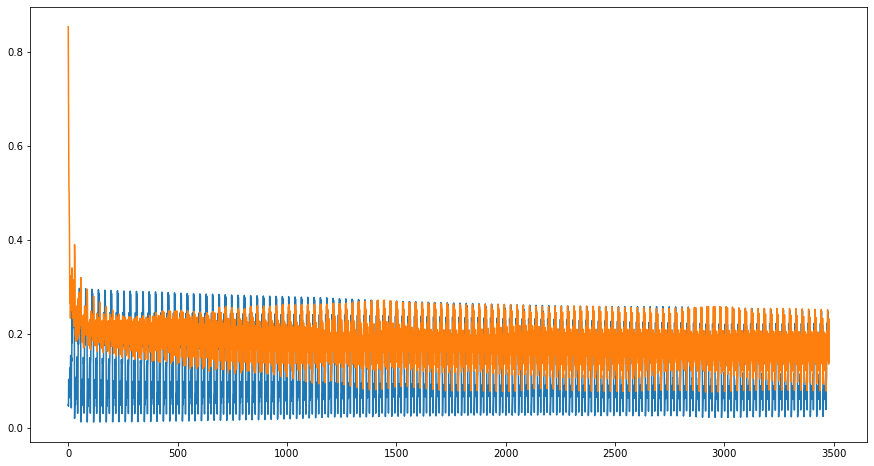

In [243]:
plt.plot(model.loss_acc)
plt.plot(model.loss_rot)

14398
450/450 [==============================] - 3s 4ms/step


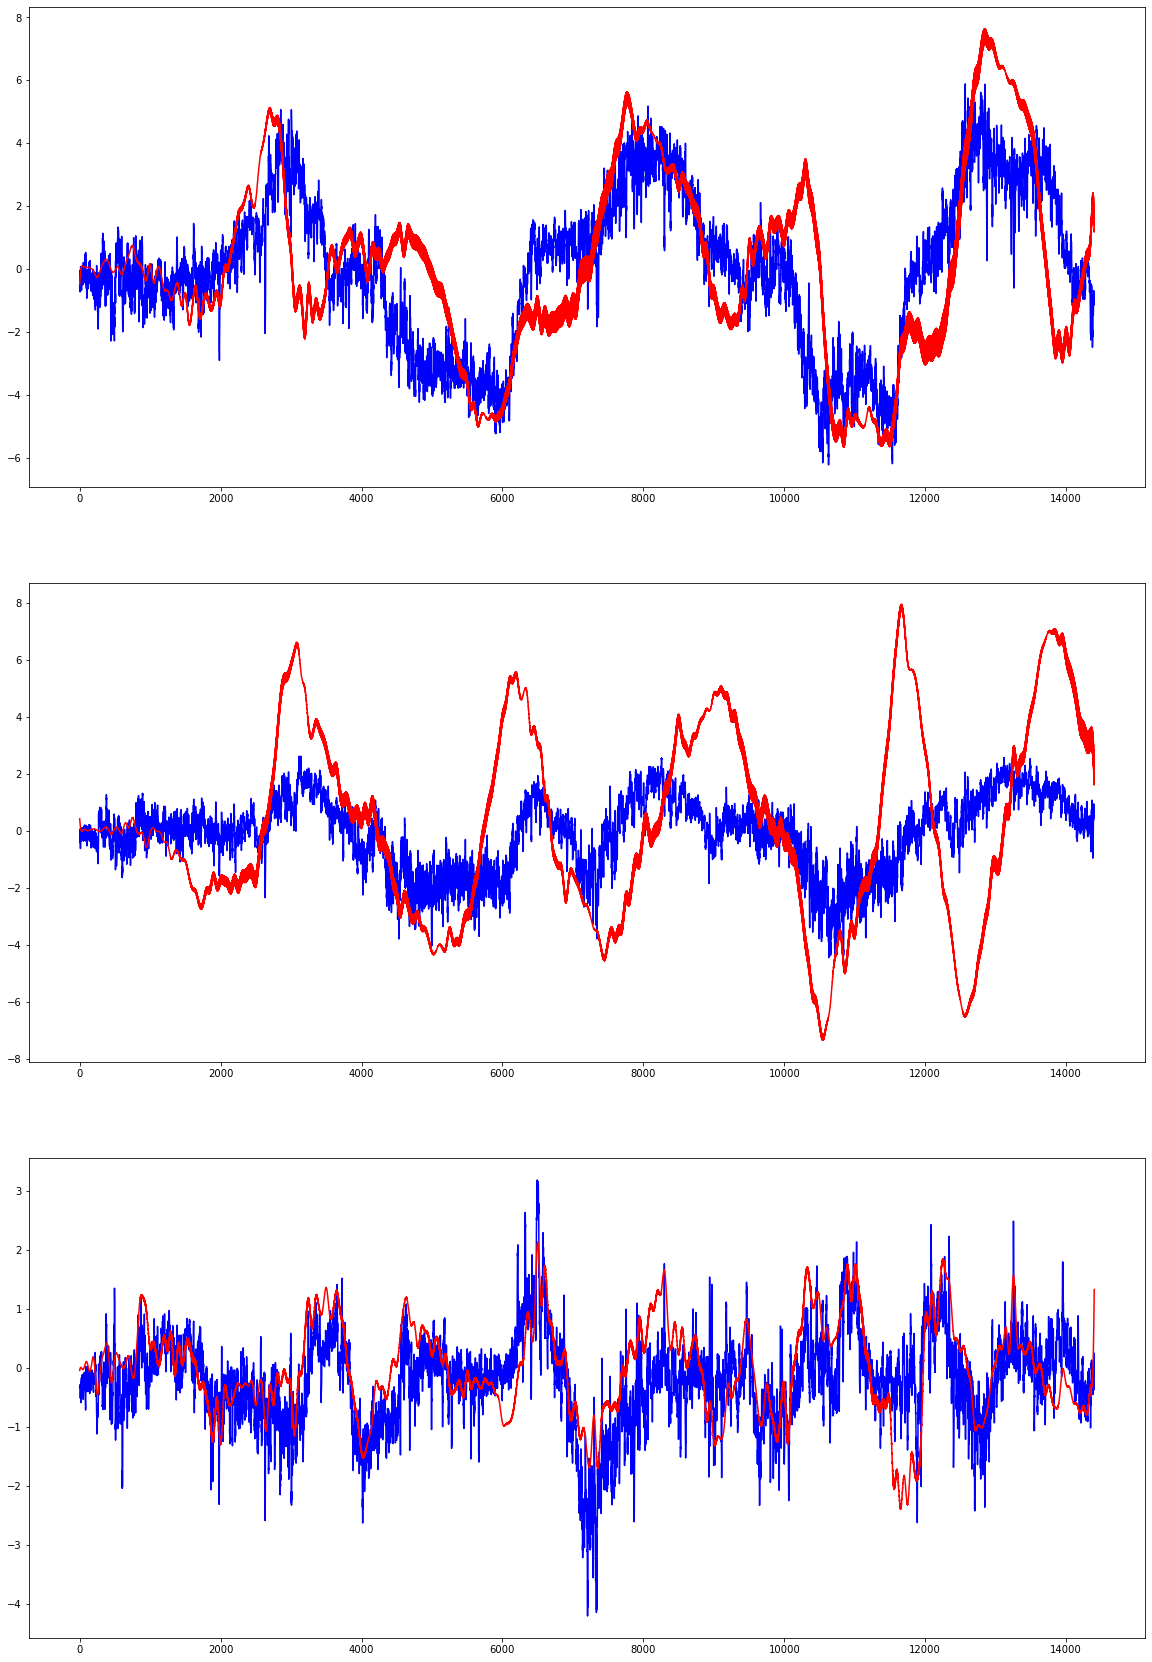

In [244]:
a = []
c = input_data.shape[0] - (TIME_RANGE_LEFT + TIME_RANGE_RIGHT - 1)
print(c)
inp = []
for i in range(c):
    inp.append(input_data[i:i+(TIME_RANGE_LEFT + TIME_RANGE_RIGHT - 1)])
inp = np.array(inp)
p = model.model.predict(inp)
fig = plt.figure(figsize=(20, 30))
for i in range(3):
    ax = fig.add_subplot(3, 1, i+1)
    ax.plot(p[:, i] * 20, color='blue')
    ax.plot(expected_acc[:c, i], color='red')


472/472 [==============================] - 2s 5ms/step


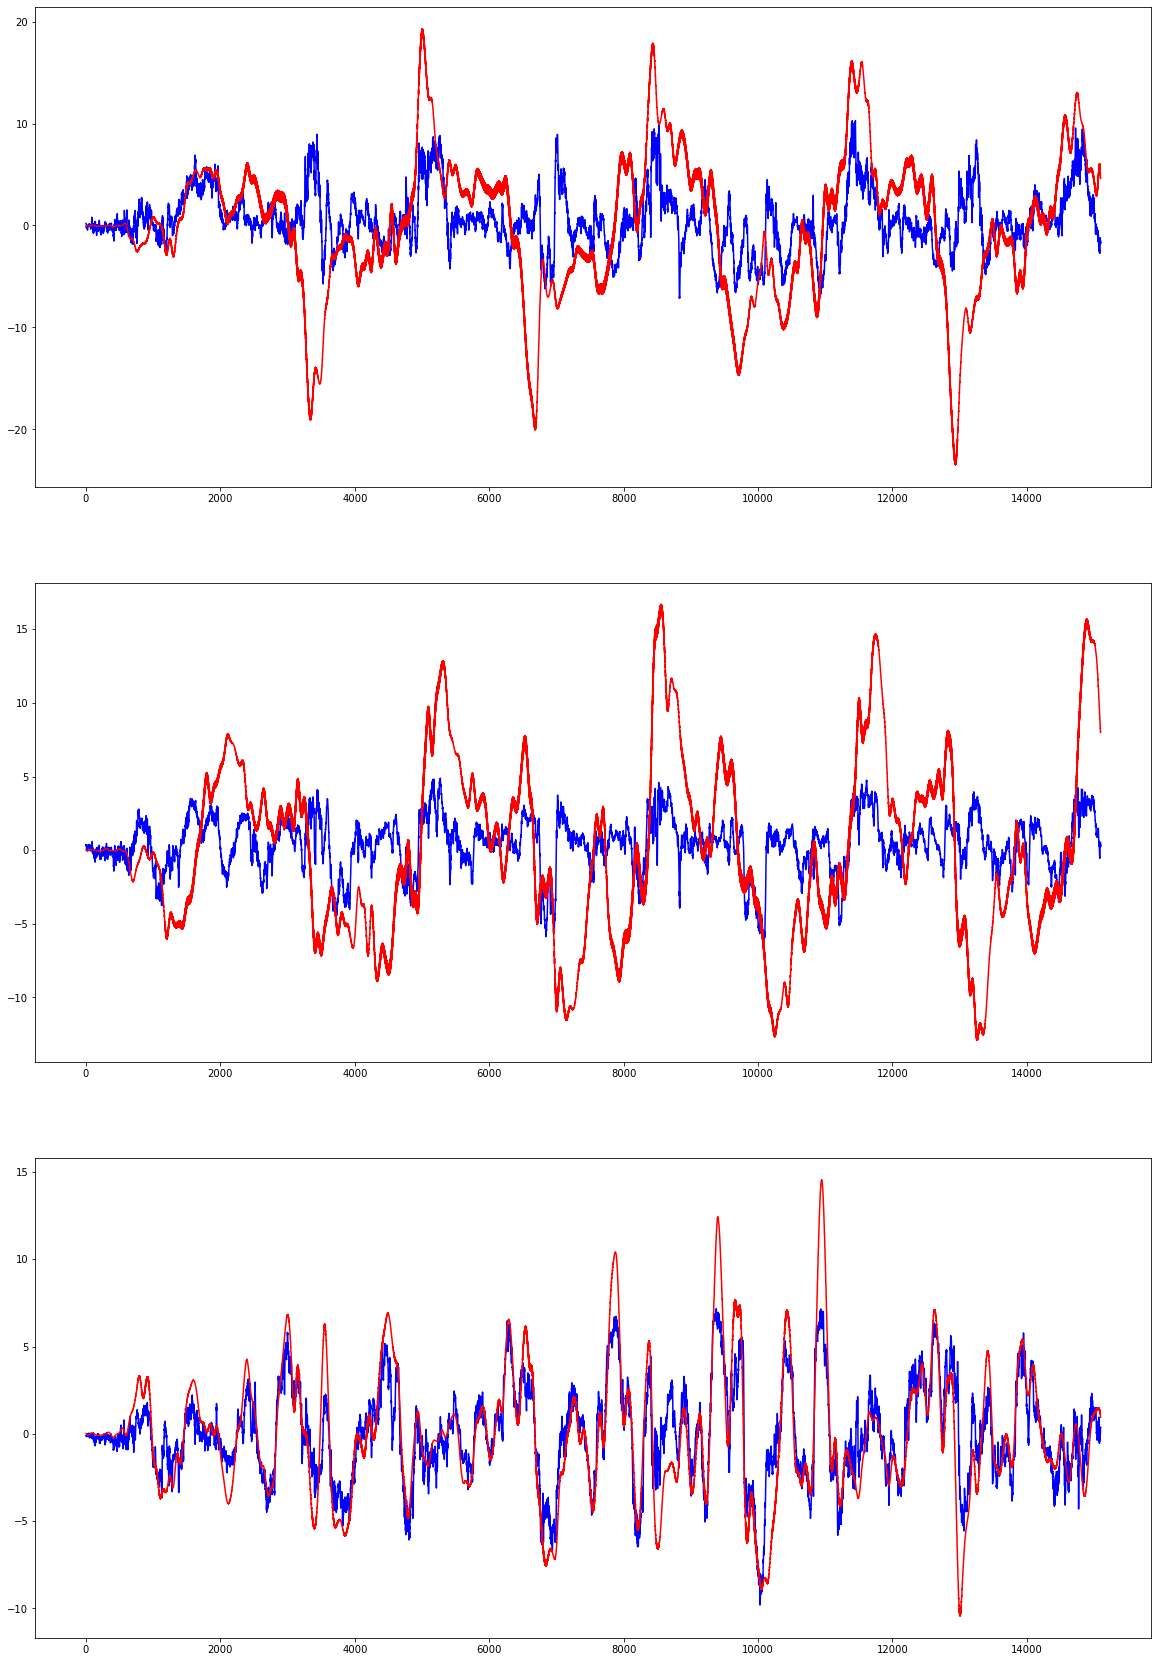

In [245]:
inp = []
c = input_data_test.shape[0] - (TIME_RANGE_LEFT + TIME_RANGE_RIGHT - 1)
for i in range(c):
    inp.append(input_data_test[i:i+14])
inp = np.array(inp)
p = model.model.predict(inp)
fig = plt.figure(figsize=(20, 30))
for i in range(3):
    ax = fig.add_subplot(3, 1, i+1)
    ax.plot(p[:, i] * 20, color='blue')
    ax.plot(expected_acc_test[:c, i], color='red')
# plt.plot(expected_acc_test[:c, 1], color='red')
# plt.plot(expected_acc_test[:c, 2], color='red')


14398
450/450 [==============================] - 2s 4ms/step
(14398, 12)


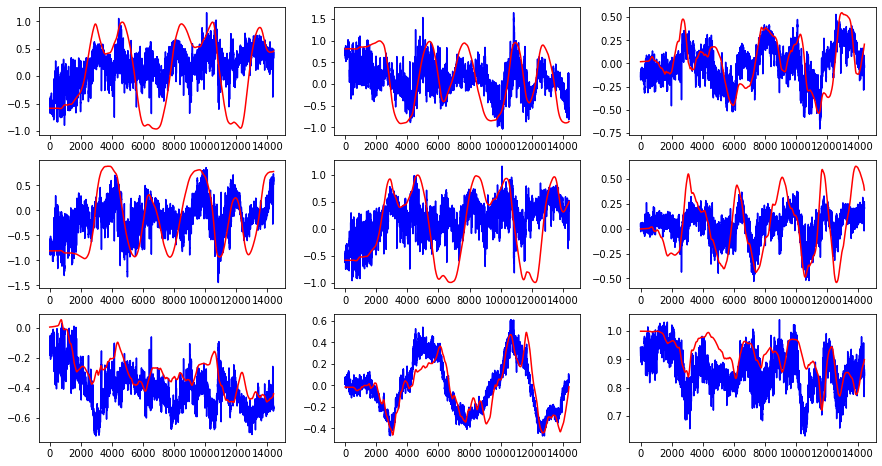

In [246]:
a = []
c = input_data.shape[0] - (TIME_RANGE_LEFT + TIME_RANGE_RIGHT - 1)
print(c)
inp = []
for i in range(c):
    inp.append(input_data[i:i+(TIME_RANGE_LEFT + TIME_RANGE_RIGHT - 1)])
inp = np.array(inp)
p = model.model.predict(inp)
print(p.shape)
fig = plt.figure()
for n in range(9):
    ax = fig.add_subplot(3, 3, n+1)
    ax.plot(p[:, 3+n] * 20, color='blue')
    ax.plot(expected_rotation[:c, 0+n], color='red')

14398
450/450 [==============================] - 2s 5ms/step


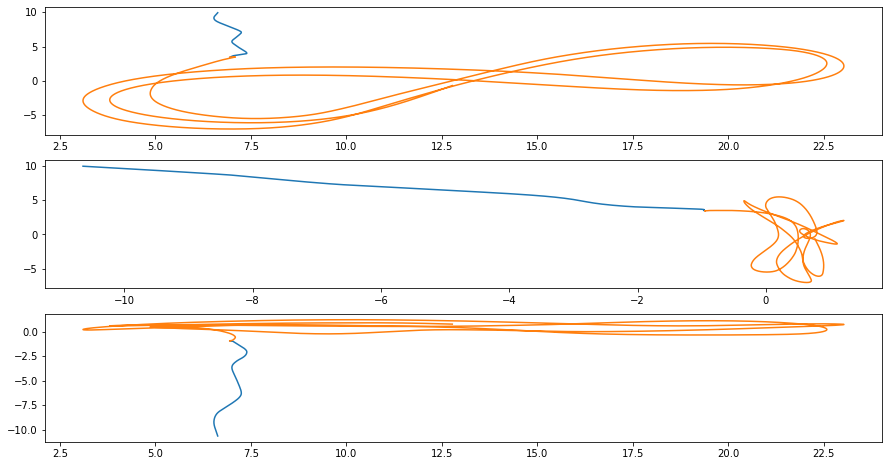

In [261]:
c = input_data.shape[0] - (TIME_RANGE_LEFT + TIME_RANGE_RIGHT - 1)
print(c)
inp = []
for i in range(c):
    inp.append(input_data[i:i+(TIME_RANGE_LEFT + TIME_RANGE_RIGHT - 1)])
inp = np.array(inp)
p = model.model.predict(inp)
ax, ay, az, xx, xy, xz, yx, yy, yz, zx, zy, zz = list(map(lambda i: p[:, i], range(12)))
pax = (ax * xx + ay * xy + az * xz) * 20
pay = (ax * yx + ay * yy + az * yz) * 20 
paz = (ax * zx + ay * zy + az * zz) * 20 
pVx = [0]
pVy = [0]
pVz = [0]
for a, t0, t1 in zip(pax, groundtruth.index.values[:-1], groundtruth.index.values[1:]):
    pVx.append(pVx[-1] + a * (t1 - t0))
for a, t0, t1 in zip(pay, groundtruth.index.values[:-1], groundtruth.index.values[1:]):
    pVy.append(pVy[-1] + a * (t1 - t0))
for a, t0, t1 in zip(paz, groundtruth.index.values[:-1], groundtruth.index.values[1:]):
    pVz.append(pVz[-1] + a * (t1 - t0))
X = [groundtruth.X.values[0]]
Y = [groundtruth.Y.values[0]]
Z = [groundtruth.Z.values[0]]
for v, t0, t1 in zip(pVx, groundtruth.index.values[:-1], groundtruth.index.values[1:]):
    X.append(X[-1] + v * (t1 - t0))
for v, t0, t1 in zip(pVy, groundtruth.index.values[:-1], groundtruth.index.values[1:]):
    Y.append(Y[-1] + v * (t1 - t0))
for v, t0, t1 in zip(pVz, groundtruth.index.values[:-1], groundtruth.index.values[1:]):
    Z.append(Z[-1] + v * (t1 - t0))
fig = plt.figure()
xy = fig.add_subplot(3, 1, 1)
xy.plot(X, Y)
xy.plot(groundtruth.X.values, groundtruth.Y.values)
zy = fig.add_subplot(3, 1, 2)
zy.plot(Z, Y)
zy.plot(groundtruth.Z.values, groundtruth.Y.values)
xz = fig.add_subplot(3, 1, 3)
xz.plot(X, Z)
xz.plot(groundtruth.X.values, groundtruth.Z.values)

15098
472/472 [==============================] - 2s 4ms/step


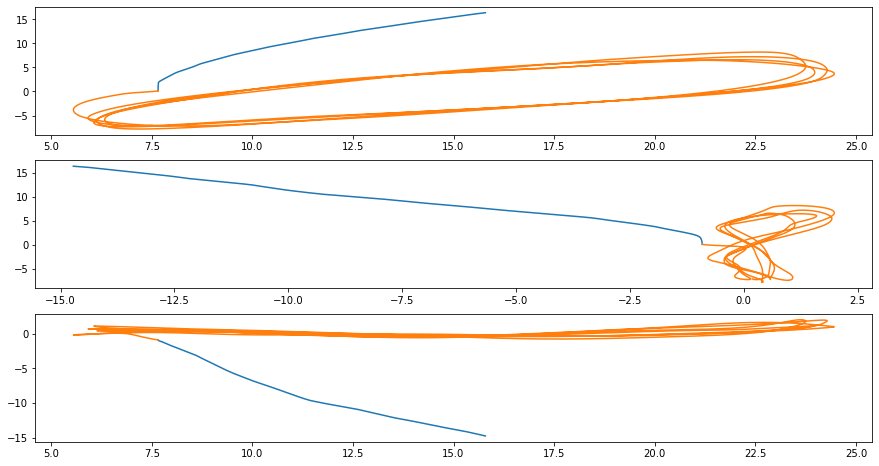

In [269]:
c = input_data_test.shape[0] - (TIME_RANGE_LEFT + TIME_RANGE_RIGHT - 1)
print(c)
inp = []
for i in range(c):
    inp.append(input_data_test[i:i+(TIME_RANGE_LEFT + TIME_RANGE_RIGHT - 1)])
inp = np.array(inp)
p = model.model.predict(inp)
ax, ay, az, xx, xy, xz, yx, yy, yz, zx, zy, zz = list(map(lambda i: p[:, i], range(12)))
pax = (ax * xx + ay * xy + az * xz) * 20
pay = (ax * yx + ay * yy + az * yz) * 20 
paz = (ax * zx + ay * zy + az * zz) * 20 

pVx = [0]
pVy = [0]
pVz = [0]
for a, t0, t1 in zip(pax, groundtruth_test.index.values[:-1], groundtruth_test.index.values[1:]):
    pVx.append(pVx[-1] + a * (t1 - t0))
for a, t0, t1 in zip(pay, groundtruth_test.index.values[:-1], groundtruth_test.index.values[1:]):
    pVy.append(pVx[-1] + a * (t1 - t0))
for a, t0, t1 in zip(paz, groundtruth_test.index.values[:-1], groundtruth_test.index.values[1:]):
    pVz.append(pVz[-1] + a * (t1 - t0))
X = [groundtruth_test.X.values[0]]
Y = [groundtruth_test.Y.values[0]]
Z = [groundtruth_test.Z.values[0]]
for v, t0, t1 in zip(pVx, groundtruth_test.index.values[:-1], groundtruth_test.index.values[1:]):
    X.append(X[-1] + v * (t1 - t0))
for v, t0, t1 in zip(pVy, groundtruth_test.index.values[:-1], groundtruth_test.index.values[1:]):
    Y.append(Y[-1] + v * (t1 - t0))
for v, t0, t1 in zip(pVz, groundtruth_test.index.values[:-1], groundtruth_test.index.values[1:]):
    Z.append(Z[-1] + v * (t1 - t0))
fig = plt.figure()
xy = fig.add_subplot(3, 1, 1)
xy.plot(X, Y)
xy.plot(groundtruth_test.X.values, groundtruth_test.Y.values)
zy = fig.add_subplot(3, 1, 2)
zy.plot(Z, Y)
zy.plot(groundtruth_test.Z.values, groundtruth_test.Y.values)
xz = fig.add_subplot(3, 1, 3)
xz.plot(X, Z)
xz.plot(groundtruth_test.X.values, groundtruth_test.Z.values)

In [270]:
# summory for 21.09

# not even close

# Ideas:
# I have to try realize same scheme RNN but with outputs many2many
# I have to try realize scheme RNN with losses by all dataset + losses by every part
#    idea from there: https://www.cs.ox.ac.uk/files/10408/motiontransformer-transferring-neural%20%283%29.pdf
#    but not a GAN, just usual RRN
# I have to try realize scheme rom there: https://www.cs.ox.ac.uk/files/10408/motiontransformer-transferring-neural%20%283%29.pdf
#   It might work
#   But right now loss functions don't obvious to me

# Thoughts:
# need to think about subsequence there
#         for i in range(groundtruth.shape[0]):
#             x1, x2, x3, x4, x5, x6, x7, x8, x9, y1, y2, y3 = groundtruth.iloc[[i]][['xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz', 'pax', 'pay', 'paz']].values[0]
#             ax, ay, az = get_drone_acc(x1, x2, x3, x4, x5, x6, x7, x8, x9, y1, y2, y3)
# might be a good idea to send extra metrics to network, such as:
#  mean
#  std
#  Kurtosis coefficient
# NEED To THINK/ why model had problems with predict values in range -10: -20
